In [ ]:
# General
import pandas as pd
import numpy as np
import re

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


# NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Plotting
import matplotlib.pyplot as plt

# Google Colaboratory
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


from bs4 import BeautifulSoup

# Doc2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import linear_model

#stemming and lemmatization
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

***200k***

In [ ]:
#Fetch 200k train file
link = 'https://drive.google.com/open?id=1lairBoF0Y74XwXiD1FHxzYwFR7NMncPo'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_200k.txt')

In [ ]:
#Fetch 200k test file
link = 'https://drive.google.com/open?id=1a_cGzgdXMPi_v9cHdzkO_-nmWN_nOcSj'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_200k.txt')

***20k***

In [ ]:
# Fetch csv file from drive, import as pandas dataframe
link = 'https://drive.google.com/open?id=1oSRw680YGg6hO2d2l5FaFsG24q40HVPT'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.txt')

In [ ]:
# Fetch test file

link = 'https://drive.google.com/open?id=1H7QHUJGldX_vm7Z7w5AB9pOEWBQGmcgs'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.txt')

In [ ]:
# Mount drive
"""
# In order to access the folder sucessfully, 
# 1. go to your personal google drive
# 2. go to shared with me
# 3. right click "Group 96 project", select "add to my drive"
# 4. then you will have "Group 96 project" in your own google drive
        
   """
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_parse(file):
    # Read file and split on identifiers
    f = open(file, 'r')
    sent_list = []
    for line in f:
        sent_dict = {}
        words = line.split()
        if len(words) <= 1:
            continue
        sent_dict["class"] =  words[0]
        sent_dict["text"] = ' '.join(words[1:])
        sent_list.append(sent_dict)  
    f.close()
    df = pd.DataFrame(sent_list)
    # df['class'] = np.where(df['class']!='CONCLUSIONS', 'OTHER', 'CONCLUSIONS')
    return df['text'], df['class']
     

***200k***

In [ ]:
X_train_200k, y_train_200k = read_parse('train_200k.txt')
X_test_200k, y_test_200k = read_parse('test_200k.txt')

***20k***

In [ ]:
X_train, y_train = read_parse('train.txt')
X_test, y_test = read_parse('test.txt')

### Data Cleaning

In [ ]:
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

X_train = X_train.apply(clean_text)


In [ ]:
X_test = X_test.apply(clean_text)

### Data Pre-Processing

**TF-IDF**


In [ ]:
vect = TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000, norm='l2', sublinear_tf=True)
X_train_tfidf_norm = vect.fit_transform(X_train)

In [ ]:
X_test_tfidf_norm = vect.fit_transform(X_test)

**Doc2Vec**

***Loading part***
- if vectorized dataset is already avaliable, just loaded it. It is much faster than train them from beginning

In [ ]:
# directly load dbow_train

#for Adam
#doc2vec_train = np.load('/content/drive/My Drive/VUA UvA/1st Year/Machine Learning/Group 96 Project/Models/dbow_train_100.npy')

#for other
doc2vec_train = np.load('/content/drive/My Drive/Group 96 Project/Models/dbow_train_100.npy')

***Loading test set***

In [ ]:
#for Adam
#doc2vec_test = np.load('/content/drive/My Drive/VUA UvA/1st Year/Machine Learning/Group 96 Project/Models/doc2vec_test.npy')

#for other
doc2vec_test = np.load('/content/drive/My Drive/Group 96 Project/Models/doc2vec_test.npy')

***Loading 200k***

In [ ]:
doc2vec_200k_train = np.load("/content/drive/My Drive/Group 96 Project/Models/doc2vec_train_200k_100d.npy")
doc2vec_200k_test = np.load("/content/drive/My Drive/Group 96 Project/Models/doc2vec_test_200k_100d.npy")

***Modelling part***

***Tokenizing***

In [ ]:
# Tokenize sentence
def tokenization(data):
  tokenized_data = []
  for i in data: 
    temp = [] 
    for j in word_tokenize(i): 
        temp.append(j.lower()) 
    tokenized_data.append(temp)
  return tokenized_data


In [ ]:
X_train_tokenized = tokenization(X_train)

***Tagging function***


In [ ]:
# Create tagged document

def tagging (tokenized_input, label):
  tagged = []
  for i in range(len(tokenized_input)):
    tagged.append(TaggedDocument(tokenized_input[i], tags=[label[i]]))
  return tagged


In [ ]:
# data without stemming or lemminzation
train_tagged = tagging(X_train_tokenized, y_train)

#row to inspect
inspect_row = 1
print(X_train_tokenized[inspect_row], train_tagged[inspect_row], sep = "\n")

['total', 'patients', 'primary', 'knee', 'oa', 'randomized', 'received', 'mg', 'day', 'prednisolone', 'received', 'placebo', 'weeks']
TaggedDocument(['total', 'patients', 'primary', 'knee', 'oa', 'randomized', 'received', 'mg', 'day', 'prednisolone', 'received', 'placebo', 'weeks'], ['METHODS'])


***Model building***

In [ ]:
# Train Doc2Vec
# Train vocab train_tagged : tagged trainset

model_name = "doc2vec_train_d300"
model_dbow = Doc2Vec(dm =0, negative=5, hs=0, sample=0, vector_size=100, min_count=2, epochs=40)
model_dbow.build_vocab(train_tagged) 
model_dbow.train(train_tagged,total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)
model_dbow.save("/content/drive/My Drive/Group 96 Project/Models/{}".format(model_name))

***vector extraction***

In [ ]:
#extract vector

def doc2vec_vector (model, tokenized_input):
  vectors = []
  for words in tokenized_input:
    vectors.append(model.infer_vector(words))
  return vectors

In [ ]:
#save the output vectors

dbow_train = doc2vec_vector (model_dbow, X_train_tokenized)
np.save('/content/drive/My Drive/Group 96 Project/Models/{}.npy'.format(model_name), dbow_train)

***Doc2vec Test set***

***Load models***
- To check the model just saved.


In [ ]:
normal_model = Doc2Vec.load('/content/drive/My Drive/Group 96 Project/Models/model_dbow_100v')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


***Vectorizing test set***

In [ ]:
#execution function tokenization, function doc2vec_vector

test_tokenized = tokenization(X_test)
doc2vec_test = doc2vec_vector(normal_model, test_tokenized)

In [ ]:
np.save('/content/drive/My Drive/Group 96 Project/Models/doc2vec_test.npy', doc2vec_test)


### Create & Visualize LSA

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)
svd_data = svd.fit_transform(X_train_tfidf_norm)

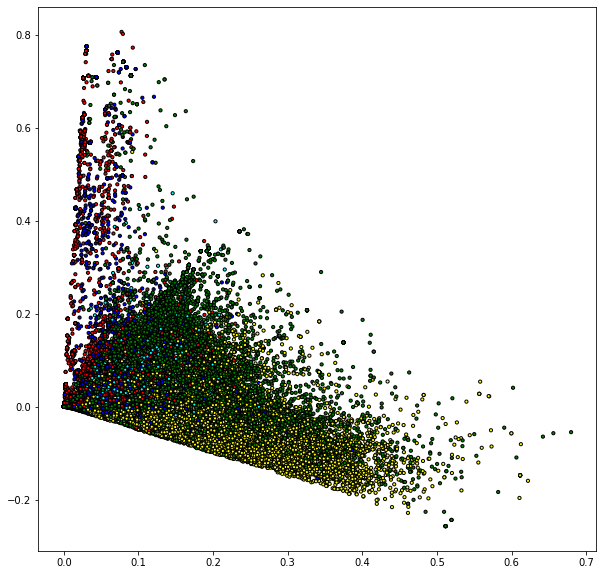

In [ ]:
labels = pd.Categorical(y_train).codes
colors = ['red','blue','green','cyan','yellow','gray','magenta']
def assigncolor(colors, assign):
    c = []
    for i in assign:
        c.append(colors[i])
    return c

plt.figure(figsize=(10, 10))
plt.scatter(svd_data[:,0],svd_data[:,1], c=assigncolor(colors,labels), marker="o", edgecolors='black', s=10)


In [ ]:
#tSNE plot
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy

tsne_train = scipy.sparse.csr_matrix([doc2vec_train[i] for i in range(len(doc2vec_train))])

type(tsne_train)
type(X_train_tfidf_norm)

scipy.sparse.csr.csr_matrix

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(tsne_train)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(tsne_train)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue= y_train,
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# for TF-IDF
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train_tfidf_norm)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue= y_train,
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

### Naive-Bayes

Note: Naive Bayes has no parameters to tune, so no cross-validation

In [ ]:
clf = MultinomialNB()
scores = cross_val_score(clf, X_train_tfidf_norm, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(X_train)/5)
print('macro f1 scores', scores)

# Investigate distribution of F1 scores for every class
clf.fit(X_train_tfidf_norm, y_train)
y_pred = nb.predict(X_train_tfidf_norm)
print('accuracy %s' % accuracy_score(y_pred, y_train))
print(classification_report(y_train, y_pred))

### Mult-Class Logistic Regression

**Logreg multinomial Macro-F1 with cv=5**: *0.680*


In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='multinomial')
param_grid = {"C": np.logspace(-3,3,7)}
grid = GridSearchCV(logreg, param_grid=param_grid, cv=5, return_train_score=True, scoring='f1_macro')
grid.fit(X_train_tfidf_norm, y_train)
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='multinomial')
scores = cross_val_score(logreg, X_train_tfidf_norm, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(X_train)/5)
print('macro f1 scores', scores)
print(mean(scores))

data per fold 36008.0
macro f1 scores [0.61361475 0.61211009 0.6101135  0.61483589 0.61308735]
0.6127523150807936


### One Vs Rest Classifier (SVM and Logistic Regression)




**Logreg OVR Macro-F1 with cv=5**: *0.680*

In [ ]:
# One vs Rest Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='ovr')
scores = cross_val_score(logreg, X_train_tfidf_norm, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(X_train)/5)
print('macro f1 scores', scores)
print(mean(scores))

data per fold 36008.0
macro f1 scores [0.60752971 0.60570132 0.60256372 0.60825916 0.60562485]
0.6059357528420115


**Linsvc OVR Macro-F1 with cv=5**: *0.675*

In [ ]:
# One vs Rest LinSVC
from sklearn.svm import LinearSVC
linsvc = LinearSVC(random_state=42, multi_class='ovr')
scores = cross_val_score(linsvc, X_train_tfidf_norm, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(X_train)/5)
print('macro f1 scores', scores)
print(mean(scores))

data per fold 36008.0
macro f1 scores [0.67694017 0.67423644 0.67344492 0.67609787 0.67507425]
0.675158728804168


In [ ]:
from sklearn.linear_model import LogisticRegression

x = X_train_tfidf_norm
y = y_train

clf = LogisticRegression(random_state=42, max_iter = 5000, multi_class= 'ovr')
scores = cross_val_score(clf, x, y, cv=5, scoring='f1_macro')

clf.fit(x,y)

print("Optimized score on training set:", clf.score(x, y))

print('macro f1 scores', scores)



### SVM

In [ ]:
# Sklearn
from sklearn.svm import SVC

#Data
x = X_train_tfidf_norm
y = y_train

## defining svm models

# linear svm
# linear_svc = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)), ("linear svc", SVC(kernal="linear"))])

= svm.SVC(kernel='linear')

# rbf svm
# rbf_svc = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer = lambda x: x)), ("rbf svc", SVC(kernal="rbf"))])






# Decision Tree


In [ ]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, doc2vec_train, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(doc2vec_train)/5)
print('macro f1 scores', scores)
sum(scores)/5

data per fold 36008.0
macro f1 scores [0.52172133 0.50345425 0.50918451 0.50968731 0.5127173 ]


0.5113529389395537

In [ ]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
X = X_train_tfidf_norm
Y = y_train
rf = RandomForestClassifier(n_estimators = 100)
scores = cross_val_score(clf, doc2vec_train, y_train, cv=5, scoring='f1_macro')
print('data per fold', len(X_train)/5)
print('macro f1 scores', scores)
sum(scores)/5

data per fold 36008.0
macro f1 scores [0.51937689 0.50429507 0.50920178 0.51125896 0.51378781]


0.5115841052530548

In [ ]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 42)
RandomizedSearchCV(rf, param_distributions = param_grid, n_iter=100, cv=5, verbose=2, random_state=42)
grid = GridSearchCV(rf, param_grid, scoring = 'f1_macro', cv=5, return_train_score =True)
grid.fit(doc2vec_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
grid

In [ ]:
np.shape(doc2vec_train)

# Doc2vec predictions
- Simple logstic regression
- Direct prediction by the most similar

***Plot and graph***

In [ ]:
my_tags = y_train.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    print(classification_report(target, predictions)) 

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

***Simple logistic regression***

In [ ]:
# select one of dataset, X_train_tfidf_norm, doc2vec_train
simple_set = doc2vec_200k_train

accuracy 0.740235606437697
confusion matrix
 [[1067  276   55  223  712]
 [ 125 8545  812  158  257]
 [  40 1230 7787  517  139]
 [ 198  233  694 2845  601]
 [ 479  339  122  618 2063]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.57      0.56      3621
 CONCLUSIONS       0.65      0.62      0.64      4571
     METHODS       0.80      0.86      0.83      9897
   OBJECTIVE       0.56      0.46      0.50      2333
     RESULTS       0.82      0.80      0.81      9713

    accuracy                           0.74     30135
   macro avg       0.68      0.66      0.67     30135
weighted avg       0.74      0.74      0.74     30135



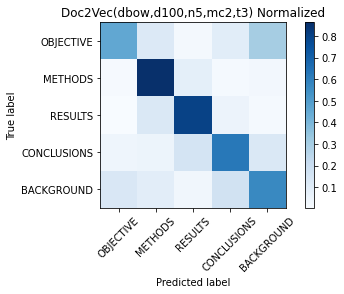

In [ ]:
#linear regression model
logreg = linear_model.LogisticRegression(penalty = "l1", max_iter= 300, n_jobs=1, C=1e5)
logreg = logreg.fit(simple_set, y_train)
#evaluation of model
evaluate_prediction(logreg.predict(doc2vec_test), y_test, title=str(normal_model))

***Direct prediction by the most similar***


In [ ]:
normal_model = Doc2Vec.load('/content/drive/My Drive/Group 96 Project/Models/model_dbow_100v')

In [ ]:
#no linear algebra, just use most similar
dbow_train_prediction = dbow_prediction(normal_model, train_tagged, 0)
dbow_train_prediction[0:10]
evaluate_prediction(dbow_train_prediction, y_train,  title=str(model_dbow))

In [ ]:
print(y_train)

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: class, Length: 180040, dtype: object
